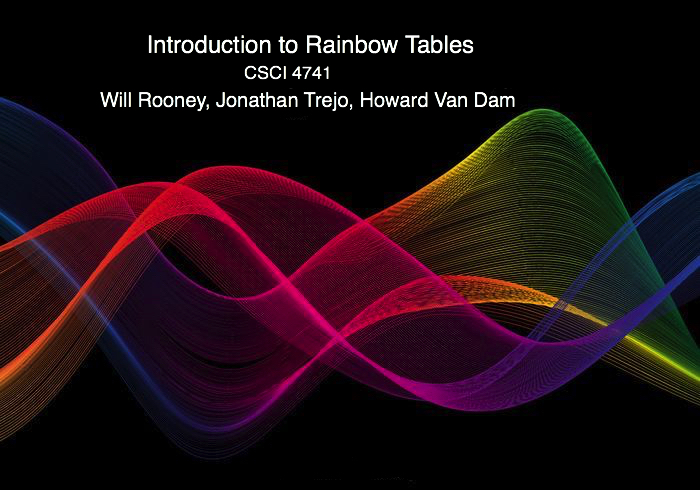

<b>What is a rainbow table?</b><br>
A rainbow table is a table filled with precomputed hash values that correspond to possible plaintext passwords.  It is a password cracking tool created by Philippe Oechslinon and based on the the work of Martin Hellman.  The name comes from a detail we will discuss shortly.<br>
<br> So, here is our attack scenario: We are an attacker trying to crack passwords on a computer we have gained access to.  We have the /etc/shadow file, which contains hashes of the users passwords.  In addition, we know the rules required for password creation. We start with an example password rule: all lower case and upper case alpha's, and 0-9 with a password length of 9 characters. Now we have to figure out what the hash value is for any password.  This is not easy, we have we have a total of 9 characters, each of which may contain 62 values, that's about 62<sup>9</sup> possibities!<br>
All we know are the values of the hashes that we found in the /etc/shadow file:<br>
    
<li>johnsont:<mark>`$`1`$`Etg2ExUZ`$`F9NTP7omafhKIlqaBMqng1</mark>:10063:0:99999:7:::</li>
<li>williamsg:<mark>`$`1`$`C4J5tWBA`$`Dke3Mq9r8SiR0Xb3AjLV2K</mark>:10042:0:99999:7:::</li>
<li>smithj:<mark>`$`6`$`ApBxgWBE`$`CBAvtkpKsON8/G2roLRlgSSf/kyhnmJ8lm5U84agccykeiL6pJ3b.d8hidD3y1u7cRcNZWZBldm47kwUugW0f1</mark>:17452::::::
<li>jonesp:<mark>`$`6`$`XuhKzqxB`$`7SFUMCYTPx8DQobJgy.iA6wbuENcptpzcjIvlo.P8V4gSMDaAbfu4FV7UNpGIr7zkyuQkzd47yHo1jYsSYNXs0</mark>:17453:0:99999:7:::
<br>
In the example above, we have four entries from an /etc/shadow file.  Each entry has the username,the password hash, and several date values such as time the password was last changed, the expiration date etc.  What we are interested in is the second value, containing the password hash itself:

jonesp:<font color="blue">`$`6`$`XuhKzqxB`$`7SFUMCYTPx8DQobJgy.iA6wbuENcptpzcjIvlo.P8V4gSMDaAbfu4FV7UNpGIr7zkyuQkzd47yHo1jYsSYNXs0</font>

There is more here than just the hash: There are three fields separated by '$':
<ol>
<li>The type of hasing algorithm used
    <ul>
       <li>1: MD5</li>
       <li>2: Blowfish</li>
       <li>5: SHA-256</li>
       <li>6: SHA-512</li>
    </ul>
  </li> 
<li>The randomly generated salt value.  A primary defence agianst the rainbow table attack, more about this later.</li>
<li>The hash value.</li>
</ol>
Note that users johnsont and williamsg have MD5 hashes while smithj and jonesp have SHA-512 hashes, these are for demonstration only, most installaitons wil use the SHA-512 algorithm.
<br>In order to recover a password, we have to find a plaintext that creates the same hash value as a value in the /etc/shadow file.
<br>
<br><b>How are we going to crack this? We have two basic strategies, each with their own problems:</b>
<ol>
    <li>First, we could guess at a password, calculate it's hash and see if that hash has an entry in the table.  This will take more processing time, but little storage space.</li>
    <li>Second, we could create a large table of passwords, one for each possible combination of allowed characters.  This strategy will take less computing time at the time of the attack, but require much more storage.</li>
</ol>
<br>The time/space tradeoff is what the Rainbow Table is all about.  A rainbow table, finds a balance between the time and space extremes by precomupting possible passwords and hashes but storing only a subset of these calculations.

<br><b>Defense agaist a Rainbow Table attack</b><br>
A salt value is a random value generated when the user creates or changes a password.  This random value makes it much harder to regenerate a hash becutes the user must cmajor component that strengthens the way a linux system stores password.

If no salt is used, a dictionary or brute force attack will have a much greater chance of recovering a password. In addition, the attacker would not know if two users passwords are the same, because a different salt would be generated for each password.

<br><b>Creating and using a rainbow table</b><br>
The code below demonstrates the creation and use of a rainbow table.  Before the attack can begin, we have to create the table:

We start with a number of randomly generated plaintexts, which represent possible passwords, and a number of iterations we are going to use to create an entry in the table.  We then proceed through an iterative process:
While the number of iterations is less than the maximum:
<ol><li>Compute the hash of the plaintext</li>
<li>Run a reducing function on the resulting hash, which creates a new plaintext</li>
</ol>
Only the beginning plaintext and the final hash are stored as an entry in the table.

<br>Rainbow tables are constructed of chains. Each chain can be constructed of certain lengths. The example shown above shows a chain of a total length of 5.
<ol>
<li>We first start with the seed value of '1234'.</li>
<li>The next step is to apply the hash and reduction functions.
[We repeat this 5 times to get the final value.]</li>
<li>We store the initial seed value and then the final value. In this case the final value is 7883
This can be repeated as many times as the user desires.</li>

<br><b>Reduction functions</b><br>
Reduction functions are a critical part in creating a rainbow table.  The purpose of the reduction function is to operate on the hash previously computed, and output a plaintext.  In the image below we see the process of creating a row in the rainbow table; starting with the plaintext, computing a hash, running the reduction function on the hash to create a new plain text, and repeating the process many times.  Each stage, or column in the diagram below, uses a different reduction function, and that is what someone called the rainbow of the rainbow table, each R<sub>x</sub>is a different reduction function.

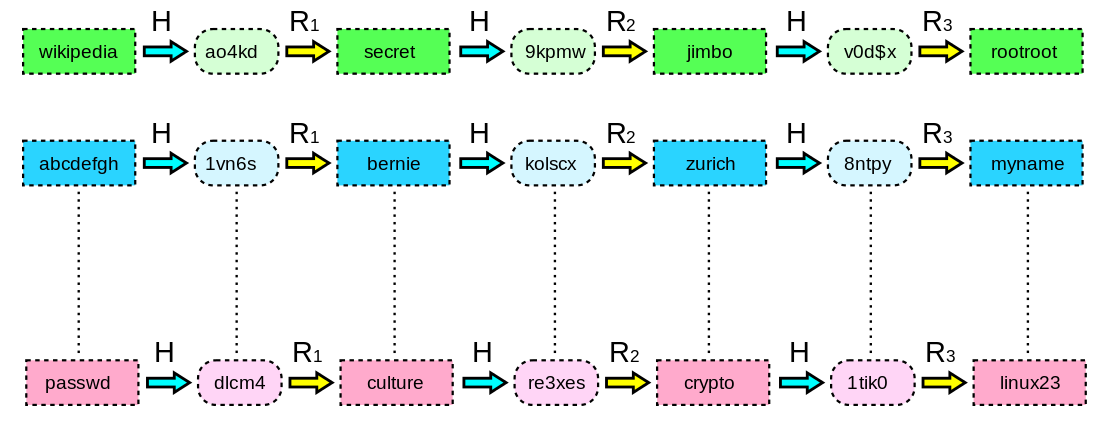

In [1]:
import RainbowTable
rainbowTable = RainbowTable.RainbowTable()
print(rainbowTable.getExampleChain(plaintext='1234', k=5))

     1234 --> 81dc9bdb52d04dc20036dbd8313ed055 --> R1
 --> 3055 --> 2836be05e71a8f34902a6e6b37350134 --> R2
 --> 0135 --> a2a68c298479b64a8536d0fd7c479ee1 --> R3
 --> 4793 --> b28d8e3ccb1ff9d46fa2d9e70222c9e7 --> R4
 --> 2300 --> 46a558d97954d0692411c861cf78ef79 --> R5 --> 7883


<b>Input a password:</b>

In [2]:
password = '1234'

<b>Create the MD5 hash:</b>

In [3]:
import hashlib
passHash = hashlib.md5(password.encode()).hexdigest()

Result:

In [4]:
print passHash

81dc9bdb52d04dc20036dbd8313ed055


<br>Let's run a rainbow table.

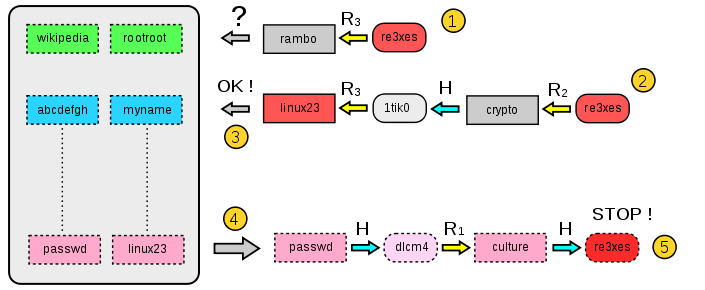

Load a pre-computed rainbow table:

In [5]:
rainbowTable.load('rainbowTable_len4_k100.txt')

The Rainbow Table:

In [1]:
for start,end in rainbowTable.table.items(): print start,'\t',end

NameError: name 'rainbowTable' is not defined

Attempt to crack the password:

In [7]:
if rainbowTable.crack(passHash):
    print 'Success! Your password is:',rainbowTable.password
else:
    print 'Attack failed.'

Attack failed.


If the attack failed, let's load another rainbow table that has a similar success rate:

In [8]:
rainbowTable.load('rainbowTable_len4_k99.txt')

if rainbowTable.crack(passHash):
    print 'Success! Your password is:',rainbowTable.password
else:
    print 'Attack failed.'

Success! Your password is: 1234


Full example where the password we are trying to find is '01234':

In [9]:
import timeit
start = timeit.default_timer()

RainbowTable.crackPassExample()

stop = timeit.default_timer()
print 'Execution time:',format(stop-start,'3.3f'),'seconds\n'

Attempting to crack 3 character password with hash: 4100c4d44da9177247e44a5fc1546778
Attack failed: trying new table
Three character password attack failed

Attempting to crack 4 character password with hash: 4100c4d44da9177247e44a5fc1546778
Attack failed: trying new table
Four character password attack failed

Attempting to crack 5 character password with hash: 4100c4d44da9177247e44a5fc1546778
Found password: 01234 

Execution time: 0.802 seconds



<br><br>--------------------------------------------------------------------------------------<br>
Sources/References:

    https://lasec.epfl.ch/~oechslin/publications/crypto03.pdf    - The original paper defining rainbow tables
    http://kestas.kuliukas.com/RainbowTables/                    - A more accessible description
    https://en.wikipedia.org/wiki/Rainbow_table                  - The Wiki page
    